# Mid-circuit measurements tools

## Introduction

In this notebook, we showcase different tools to improve the qubits' readout fidelity, using mid-circuit measurement tools (MCMs). In particular, we will implement post-selection (PS) and maximum likelihood 3 readout (ML-3 RO).

## Maximum-likelihood 3 readout and post-selection

The ML-3 RO can be implemented when measuring the qubit. Instead of reading out the state only once (ML-1 RO), we perform three measurements back-to-back. Depending on the 3 measurement outcomes, we determine the qubit's state. It allows us to gain additional information about the qubit state over an extended duration by tracking the trajectory of the state over the three measurements.

To correctly assign the qubit's state, we measure for what 3-measurement the qubit is more likely to be in either $\left|0\right\rangle$ or $\left|1\right\rangle$. To characterize the readout, we use the circuit below (Figure 1). We prepare the qubits in the $\left|0\right\rangle$ or $\left|1\right\rangle$ state and perform three back-to-back measurements. We calculate the probability to obtain a combination of 3-measurement outcomes depending on the initial state of the qubit. So, when a qubit state is measured using ML-3 RO, the 3-measurement combination can be correlated to the most likely qubit state.

Post-selection is implemented by measuring the qubit right after the initialization. If the qubit is not in the desired state, we disregard the data from that shot.

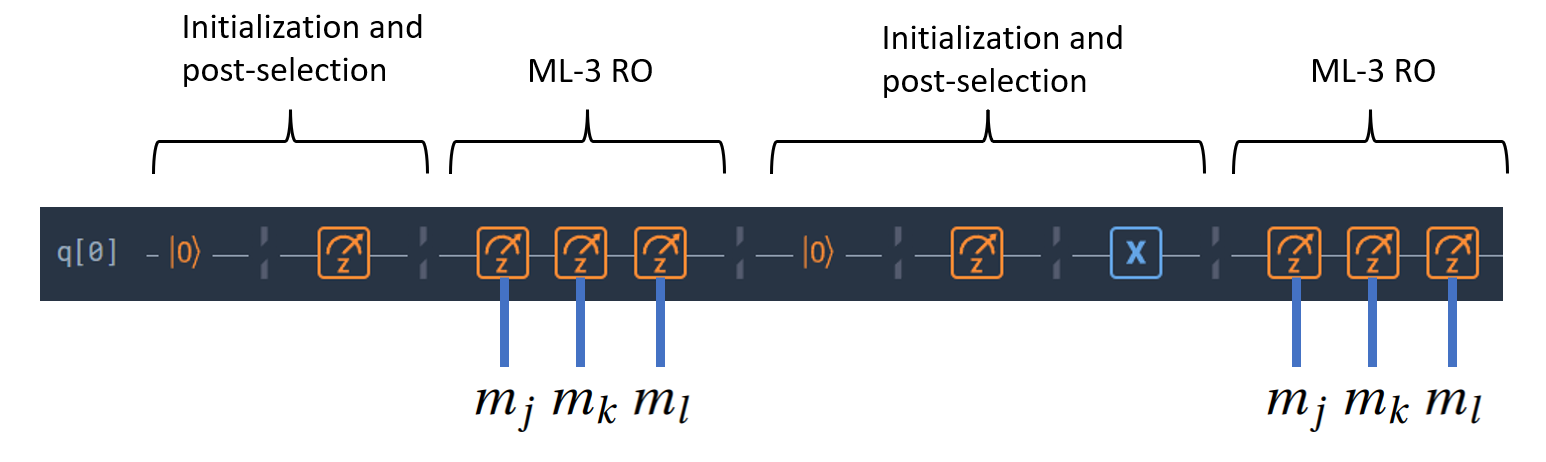
(**Figure 1.** ML-3 RO calibration procedure for one qubit. $m_{j}$,$m_{k}$,$m_{l}$ are the three measurements that characterize the ML-3 RO procedure. With only one job, we fully characterize the ML-3 RO (TV mode). First, we prepare the qubit in the $\left|0\right\rangle$ state and we measure it three times. Then, the qubit is initialized in the $\left|1\right\rangle$ state and measured three times again.) 

The function below runs the ML3-RO characterization measurement in Quantum Inspire Starmon-5. You can find the utility functions that we use below to create the local directory and save the data in the public GitHub repository: https://github.com/DiCarloLab-Delft/QuantumInspireUtilities/tree/main

In [2]:
from UtilityFunctions import *

save_account('6d3345eacf0d4489ce086556e786be56cb5cf82a')
DataPath = NewDay()

Creation of the directory C:\Users\rdicarlo\OneDrive - Delft University of Technology\Desktop\Delft\Quantum_Inspire\Data/Data_230630 failed


In [5]:
maxShots = 16384

def MCM(suffix: str="", shots: int = maxShots, backend: int=1):
    basename='Post_selection'
    histname, cqasmname, rawname = PrepFile(basename, suffix, doraw = 1)
    

    for k in tqdm(range(1), desc=histname):
        index=2**(2);
        qasm_string = """
            version 1.0
            qubits 5
            prep_z q[0:4]
            barrier q[0:4]
            measure_z q[0:4]
            
            barrier q[0:4]
            measure_z q[0:4]
            barrier q[0:4]
            measure_z q[0:4]
            barrier q[0:4]
            measure_z q[0:4]
            
            barrier q[0:4]
            
            prep_z q[0:4]
        
            barrier q[0:4]
            measure_z q[0:4]
                        
            barrier q[0:4]
            X q[0:4]
                        
            barrier q[0:4]
            measure_z q[0:4]
            barrier q[0:4]
            measure_z q[0:4]
            barrier q[0:4]
            measure_z q[0:4]
            
            barrier q[0:4]         
            """.format(qubit = qubit)

        results = API_RunAndSave(1, qasmprog=qasm_string, histname=histname, cqasmname = cqasmname, shots=shots, backend=backend, lastonly = 0, getresults = 1)
        API_SaveRawData(results, 1, rawname)
    return

We acquire a lot of data to get a good statistic of the outcome.

In [5]:
rep = 2 # how many consecutive times you want to run the job?
for k in range(rep):
    MCM(shots = maxShots, suffix="repeated_{}".format(k))

In [6]:
bins_sliced = []

for i in range(rep):
    filedata = os.path.join(DataPath, 'Hist_Post_selection_repeated_{}_API.txt'.format(i))
    
    foldername_bins = os.path.join(DataPath, 'Raw_' + filedata[112:-4]) # you may need to change the indices in filedata to have the correct file name 
    filename_bins = os.path.join(foldername_bins,'Raw_' + filedata[112:-4]+'_1.csv') # you may need to change the indices in filedata to have the correct file name 
    bins_loaded = np.loadtxt(filename_bins, delimiter=',', skiprows=1, dtype='str') #load all output bins into an array
    for j in range(len(bins_loaded)):
        bins_sliced.append(bins_loaded[j][1:])

In [7]:
bins = ['$|000\\rangle$','$|001\\rangle$','$|010\\rangle$','$|011\\rangle$', '$|100\\rangle$','$|101\\rangle$','$|110\\rangle$','$|111\\rangle$']

bins_int = [np.array([0, 0, 0]), np.array([0, 0, 1]), np.array([0, 1, 0]), np.array([0, 1, 1]),
        np.array([1, 0, 0]), np.array([1, 0, 1]), np.array([1, 1, 0]), np.array([1, 1, 1])]

The following function calculates the frequencies of the measurement combinations that are related to the different initial states, the returned "th" from the function below is this threshold. This integer number tells us which qubit's state correspond to the 3-bit outcome.

In [13]:
def measures_selecting(bins_sliced,qubit):
    selec = np.empty((len(bins_sliced),len(bins_sliced[1])))
    for i in range(len(bins_sliced)):
        for j in range(8):
            selec[i][j] = bins_sliced[i][j][qubit]             # obtaining the right measurements based on the qubit.
            
    meas0 = selec[:,0:4]                  #obtaining the measurements for state 0 of qubit
    meas1 = selec[:,4:8]
    
    # post-selection
    meas0_selec = np.array([2,2,2])
    meas1_selec = np.array([2,2,2])
    
    for i in range(len(meas0)):
        if meas0[i][0] == 0:
            meas0_selec = np.vstack((meas0_selec,meas0[i][1:]))
        if meas1[i][0] == 0:
            meas1_selec = np.vstack((meas1_selec,meas1[i][1:]))
            
    meas0 = meas0_selec[:][1:]
    meas1 = meas1_selec[:][1:]
    
    
    unique_rows0, counts0 = np.unique(meas0, axis=0, return_counts=True)
    unique_rows1, counts1 = np.unique(meas1, axis=0, return_counts=True)
    
    unique_rows0 = unique_rows0.astype(int)
    unique_rows1 = unique_rows1.astype(int)
    
    
    counts_tot0 = np.zeros(8)
    counts_tot1 = np.zeros(8)
    
    meas0 = meas0.astype(int)
    meas1 = meas1.astype(int)
    
    for j in range(len(bins)):
        for i in range(len(meas0)):            
            if np.array_equal(meas0[i], bins_int[j]):
                counts_tot0[j] += 1
                
        for l in range(len(meas1)):
            if np.array_equal(meas1[l], bins_int[j]):
                counts_tot1[j] += 1
                
    prob0 = counts_tot0 / len(meas0)
    prob1 = counts_tot1 / len(meas1)
    
    th = 0
    while prob0[th]>prob1[th]:    
        th = th+1

    return th, prob0, prob1

In [14]:
i0, prob0_0, prob0_1 = measures_selecting(bins_sliced,0)
print('just')
i1, prob1_0, prob1_1 = measures_selecting(bins_sliced,1)
print('wait')
i2, prob2_0, prob2_1 = measures_selecting(bins_sliced,2)
print('a')
i3, prob3_0, prob3_1 = measures_selecting(bins_sliced,3)
print('minute')
i4, prob4_0, prob4_1 = measures_selecting(bins_sliced,4)
print('done!')

just
wait
a
minute
done!


The graphs for each qubit are shown below. If we consider only the first measurement (ML-1 RO), we will assign the outcome '011' erroneously to the state $\left|0\right\rangle$. Indeed, we see that we are more likely to measure outcome '011' when the qubit is initialized in $\left|1\right\rangle$. So, we move the threshold one step to the left.
Different qubits can have different thresholds to asses the state $\left|0\right\rangle$ or $\left|1\right\rangle$. While the ML-1 RO threshold is always between 0 and 1, in the ML-3 RO procedure, it can shift over time.

1.0000000000000002 1.0


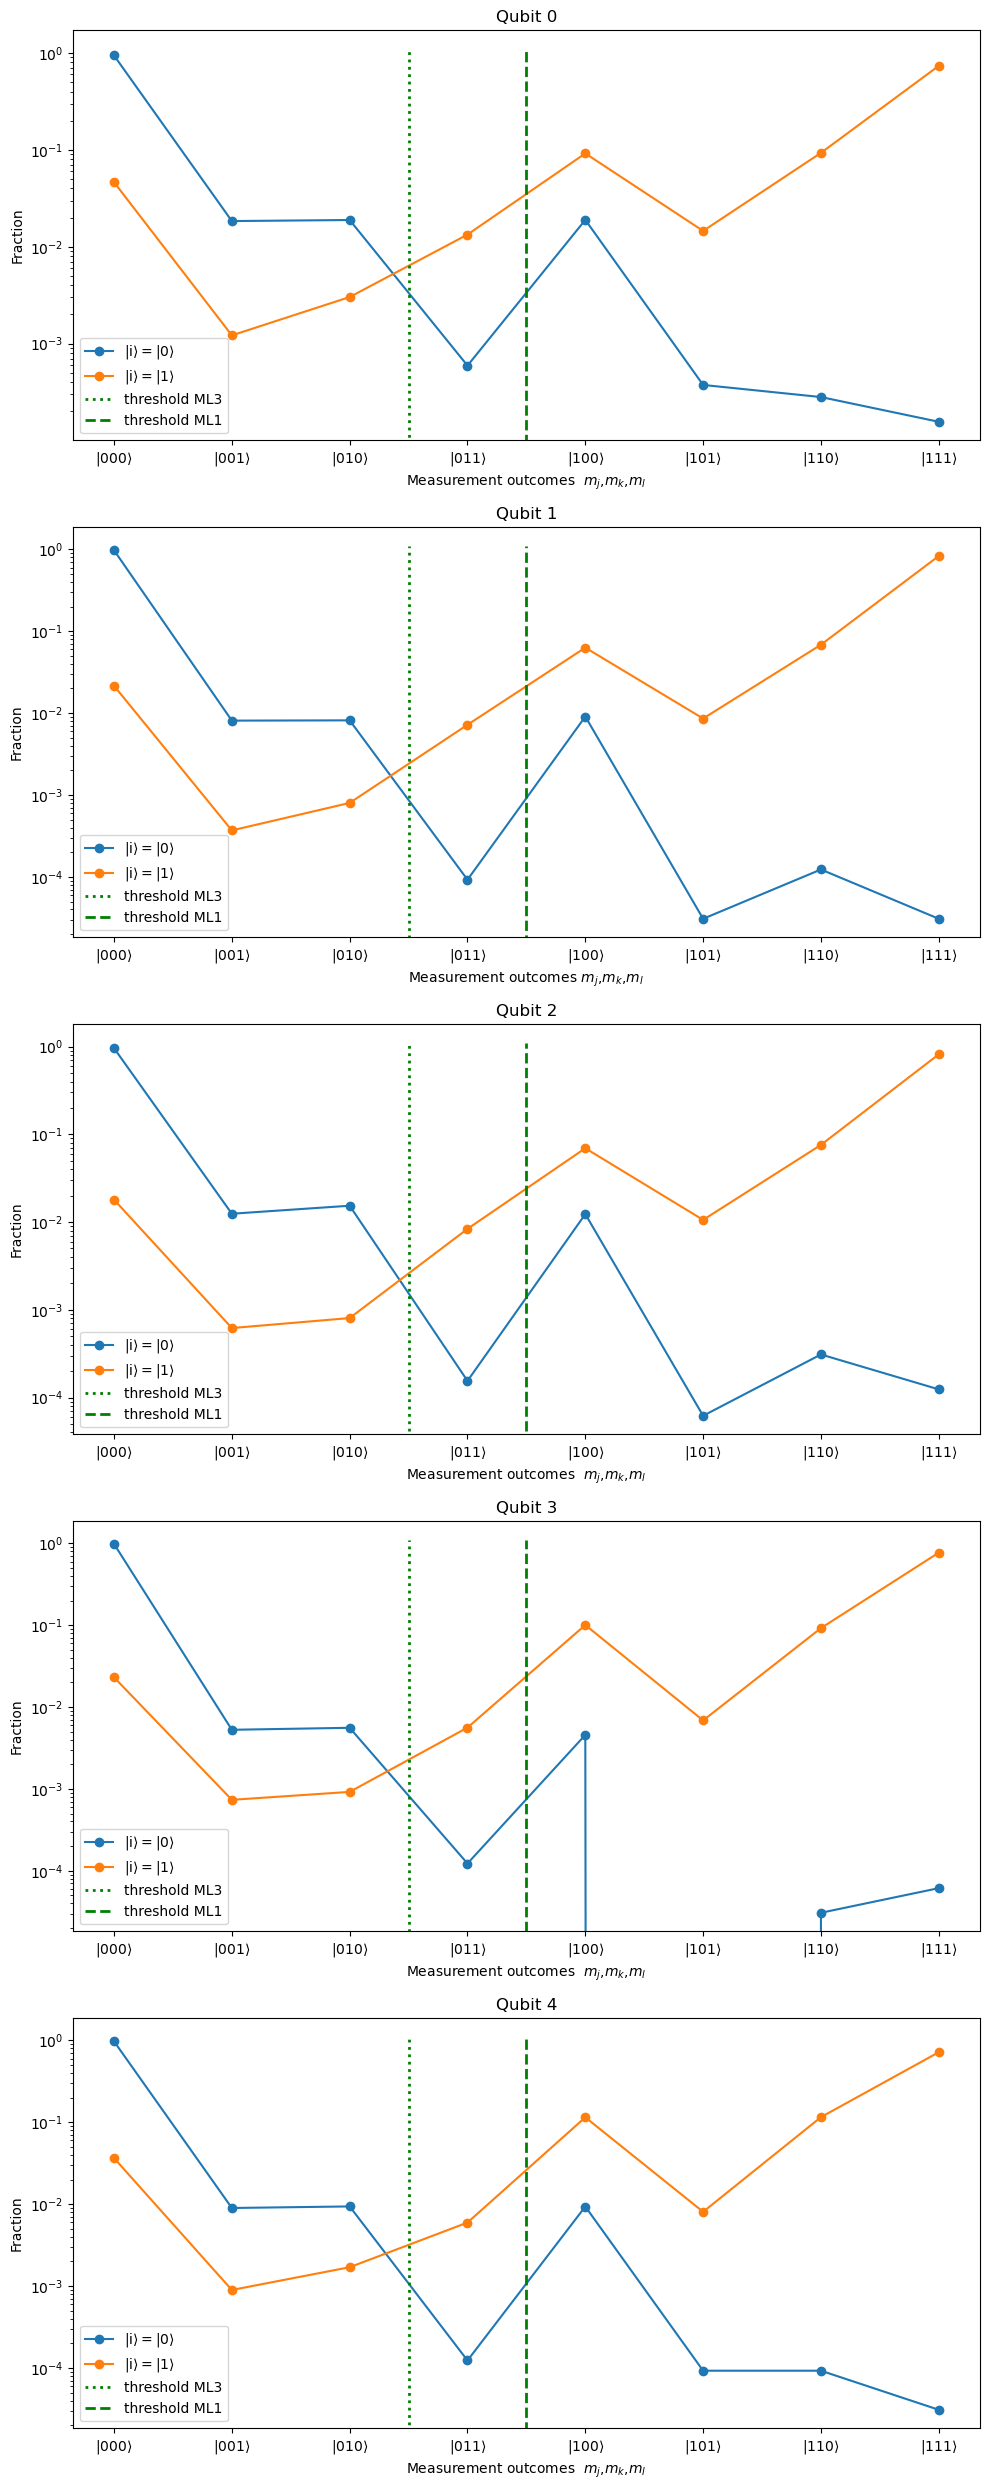

In [15]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 25))
print(sum(prob0_0),sum(prob0_1))
# Plot histograms for each qubit in a separate subplot
axs[0].plot(bins, prob0_0, '-o', label=r'$\mathrm{|i\rightangle = |0\rightangle}$')
axs[0].plot(bins, prob0_1, '-o', label=r'$\mathrm{|i\rightangle = |1\rightangle}$')
axs[0].vlines(x = i0-0.5, ymin=0, ymax=1.1, colors='green', ls=':', lw=2, label='threshold ML3')
axs[0].vlines(x = 3.5, ymin=0, ymax=1.1, colors='green', ls='--', lw=2, label='threshold ML1')
axs[0].set_title('Qubit 0')
axs[0].set_xlabel('Measurement outcomes  $m_{j}$,$m_{k}$,$m_{l}$ ')
axs[0].set_ylabel('Fraction')
axs[0].set_yscale('log')
axs[0].legend()

axs[1].plot(bins, prob1_0, '-o', label=r'$\mathrm{|i\rightangle = |0\rightangle}$')
axs[1].plot(bins, prob1_1, '-o', label=r'$\mathrm{|i\rightangle = |1\rightangle}$')
axs[1].vlines(x = i1-0.5, ymin=0, ymax=1.1, colors='green', ls=':', lw=2, label='threshold ML3')
axs[1].vlines(x = 3.5, ymin=0, ymax=1.1, colors='green', ls='--', lw=2, label='threshold ML1')
axs[1].set_title('Qubit 1')
axs[1].set_xlabel('Measurement outcomes $m_{j}$,$m_{k}$,$m_{l}$')
axs[1].set_ylabel('Fraction')
axs[1].set_yscale('log')
axs[1].legend()

axs[2].plot(bins, prob2_0, '-o', label=r'$\mathrm{|i\rightangle = |0\rightangle}$')
axs[2].plot(bins, prob2_1, '-o', label=r'$\mathrm{|i\rightangle = |1\rightangle}$')
axs[2].vlines(x = i2-0.5, ymin=0, ymax=1.1, colors='green', ls=':', lw=2, label='threshold ML3')
axs[2].vlines(x = 3.5, ymin=0, ymax=1.1, colors='green', ls='--', lw=2, label='threshold ML1')
axs[2].set_title('Qubit 2')
axs[2].set_xlabel('Measurement outcomes  $m_{j}$,$m_{k}$,$m_{l}$')
axs[2].set_ylabel('Fraction')
axs[2].set_yscale('log')
axs[2].legend()

axs[3].plot(bins, prob3_0, '-o', label=r'$\mathrm{|i\rightangle = |0\rightangle}$')
axs[3].plot(bins, prob3_1, '-o', label=r'$\mathrm{|i\rightangle = |1\rightangle}$')
axs[3].vlines(x = i3-0.5, ymin=0, ymax=1.1, colors='green', ls=':', lw=2, label='threshold ML3')
axs[3].vlines(x = 3.5, ymin=0, ymax=1.1, colors='green', ls='--', lw=2, label='threshold ML1')
axs[3].set_title('Qubit 3')
axs[3].set_xlabel('Measurement outcomes  $m_{j}$,$m_{k}$,$m_{l}$')
axs[3].set_ylabel('Fraction')
axs[3].set_yscale('log')
axs[3].legend()

axs[4].plot(bins, prob4_0, '-o', label=r'$\mathrm{|i\rightangle = |0\rightangle}$')
axs[4].plot(bins, prob4_1, '-o', label=r'$\mathrm{|i\rightangle = |1\rightangle}$')
axs[4].vlines(x = i4-0.5, ymin=0, ymax=1.1, colors='green', ls=':', lw=2, label='threshold ML3')
axs[4].vlines(x = 3.5, ymin=0, ymax=1.1, colors='green', ls='--', lw=2, label='threshold ML1')
axs[4].set_title('Qubit 4')
axs[4].set_xlabel('Measurement outcomes  $m_{j}$,$m_{k}$,$m_{l}$')
axs[4].set_ylabel('Fraction')
axs[4].set_yscale('log')
axs[4].legend()

# Adjust the spacing between subplots
plt.tight_layout()
# plt.savefig('qubits.png')
# Show the plot
plt.show()

The fractions on the Y-axis indicate the  probability to obtain a certain measurement outocome, given the initial state of the qubit. The threshold in the picture discriminates between the $|0\rangle$ and $|1\rangle$ outcome.

## Calculating increase in fidelity

To compare the ML3 and ML1 readout procedures we calculate the average assignment fidelity in the two cases. We use the equation

\begin{equation}
    \label{eq: Hadamard}
    F_{aa} = 1-\frac{\epsilon_{01} + \epsilon_{10}}{2}
\end{equation}

The values of $\epsilon_{01}$ and $\epsilon_{10}$ are the probabilities that we wrongly assign the $\left|1\right\rangle$ and $\left|0\right\rangle$ state respectively. 

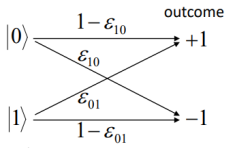
(**Figure 2.** Schematic of the readout model.) 

In [13]:
def assignment_fidelity(bins_sliced,qubit,ML3,i0):
    
    
    selec = np.empty((len(bins_sliced),len(bins_sliced[1])))
    for i in range(len(bins_sliced)):
        for j in range(8):
            selec[i][j] = bins_sliced[i][j][qubit]             # obtaining the right measurements based on the qubit.
            
    meas0 = selec[:,0:4]                  #obtaining the measurements for state 0 of qubit
    meas1 = selec[:,4:8]
    
    # post-selection
    meas0_selec = np.array([2,2,2])
    meas1_selec = np.array([2,2,2])
    
    for i in range(len(meas0)):
        if meas0[i][0] == 0:
            meas0_selec = np.vstack((meas0_selec,meas0[i][1:]))
        if meas1[i][0] == 0:
            meas1_selec = np.vstack((meas1_selec,meas1[i][1:]))
    
    meas0 = meas0_selec[:][1:]
    meas1 = meas1_selec[:][1:]

    freq0 = np.zeros(2)  # indice 0 corr to 0
    freq1 = np.zeros(2)
    
    for z in range(len(meas0)):
        if ML3 == 1:   
            
            string0 = '{m0}{m1}{m2}'.format(m0 = int(meas0[z][0]), m1 = int(meas0[z][1]), m2 = int(meas0[z][2]))   
            
            if int(string0,2) >= i0:                             
                freq0[1] += 1
            else:                 
                freq0[0] += 1    
        if ML3 != 1:  
            string0 = '{m0}'.format(m0 = int(meas0[z][0]))
            if string0 == '1':                                  
                freq0[1] += 1
            else:                 
                freq0[0] += 1    
                
    for z in range(len(meas1)):
        if ML3 == 1: 
            string1 = '{m0}{m1}{m2}'.format(m0 = int(meas1[z][0]), m1 = int(meas1[z][1]), m2 = int(meas1[z][2]))     
            if int(string1,2) >= i0:                             
                freq1[1] += 1                
            else:                 
                freq1[0] += 1
                
        
        if ML3 != 1:
            
            string1 = '{m0}'.format(m0 = int(meas1[z][0]))
            if string1 == '1':                
                freq1[1] += 1
            else:             
                freq1[0] += 1
          
    e10 = freq0[1]/np.sum(freq0) 
    e01 = freq1[0]/np.sum(freq1) 
    
    Fid = 1-(e10+e01)/2           # average assignment fidelity
    return Fid

In [14]:
# This code can take up to 10 minutes to run
# q0
Fid_q0_ML3 = assignment_fidelity(bins_sliced, 0, 1, i0)*100 # %
Fid_q0_ML1 = assignment_fidelity(bins_sliced, 0, 0, i0)*100 # %
diff_q0 = Fid_q0_ML3 - Fid_q0_ML1

# q1
Fid_q1_ML3 = assignment_fidelity(bins_sliced, 1, 1, i1)*100 # %
Fid_q1_ML1 = assignment_fidelity(bins_sliced, 1, 0, i1)*100 # %
diff_q1 = Fid_q1_ML3 - Fid_q1_ML1

# q2
Fid_q2_ML3 = assignment_fidelity(bins_sliced, 2, 1, i2)*100 # %
Fid_q2_ML1 = assignment_fidelity(bins_sliced, 2, 0, i2)*100 # %
diff_q2 = Fid_q2_ML3 - Fid_q2_ML1

# q3
Fid_q3_ML3 = assignment_fidelity(bins_sliced, 3, 1, i3)*100 # %
Fid_q3_ML1 = assignment_fidelity(bins_sliced, 3, 0, i3)*100 # %
diff_q3 = Fid_q3_ML3 - Fid_q3_ML1

# q4
Fid_q4_ML3 = assignment_fidelity(bins_sliced, 4, 1, i4)*100 # %
Fid_q4_ML1 = assignment_fidelity(bins_sliced, 4, 0, i4)*100 # %
diff_q4 = Fid_q4_ML3 - Fid_q4_ML1

# Difference array
difference = [diff_q0, diff_q1, diff_q2, diff_q3, diff_q4]  #convert to %

The graph below shows the increase (blue) or decrease (red) in average assignment fidelity going from ML-1 to ML-3. 

The thresholds are: 3, 3, 3, 3, 3.


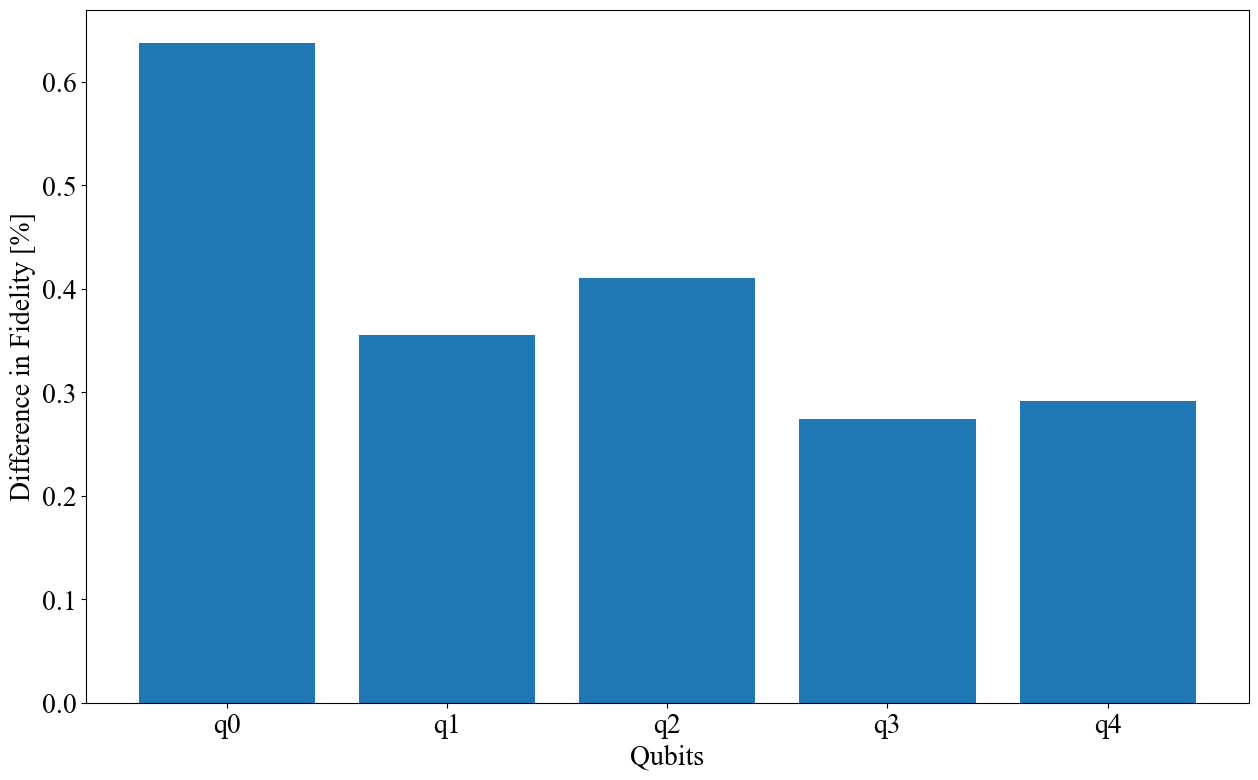

In [15]:
bins = ['q0', 'q1', 'q2', 'q3', 'q4']
print('The thresholds are: {i0}, {i1}, {i2}, {i3}, {i4}.'.format(i0=i0,i1=i1,i2=i2,i3=i3,i4=i4))

# Calculate the colors for the bars based on the sign of the differences
colors = np.where(np.array(difference) >= 0, '0', 'red')
colors = np.where(np.array(difference) < 0, '0', 'C0')

plt.figure(figsize=(15, 9))
font = {'family': 'Times New Roman', 'weight': 'normal', 'size': 20}
plt.rc('font', **font)

plt.bar(bins, difference, color=colors)

plt.xlabel('Qubits')
plt.ylabel('Difference in Fidelity [%]')
plt.show()

The fidelities with and without the MCM are shown below.

In [16]:
# q0
print('q0: ML3:', np.round(Fid_q0_ML3, 3), '; ML1:', np.round(Fid_q0_ML1, 3),'%')
# q1
print('q1: ML3:', np.round(Fid_q1_ML3, 3), '; ML1:', np.round(Fid_q1_ML1, 3),'%')
# q2
print('q2: ML3:', np.round(Fid_q2_ML3, 3), '; ML1:', np.round(Fid_q2_ML1, 3),'%')
# q3
print('q3: ML3:', np.round(Fid_q3_ML3, 3), '; ML1:', np.round(Fid_q3_ML1, 3),'%')
# q4
print('q4: ML3:', np.round(Fid_q4_ML3, 3), '; ML1:', np.round(Fid_q4_ML1, 3),'%')

q0: ML3: 96.454 ; ML1: 95.816 %
q1: ML3: 98.396 ; ML1: 98.04 %
q2: ML3: 98.381 ; ML1: 97.971 %
q3: ML3: 98.524 ; ML1: 98.25 %
q4: ML3: 97.56 ; ML1: 97.268 %


As we can see, the assignment fidelity of all qubits has increased using ML-3 RO. This gives has up to 0.7% higher readout fidelity without any changes in the qubit parameters.